# Trying qeom with qiskit and transform to braket on IonQ Aria1 and IQM Garnet

## qeom in qiskit

In [1]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [2]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

In [3]:
from qiskit_algorithms import NumPyEigensolver

numpy_solver = NumPyEigensolver(k=4, filter_criterion=es_problem.get_default_filter_criterion())

In [4]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

estimator = Estimator()
# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
solver = VQE(estimator, ansatz, SLSQP())
solver.initial_point = [0.0] * ansatz.num_parameters
gse = GroundStateEigensolver(mapper, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)

In [5]:
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver

numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(es_problem)

qeom_results = qeom_excited_states_solver.solve(es_problem)

print(numpy_results)
print("\n\n")
print(qeom_results)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -0.882722150245
> Total excited state energy (Hartree): -0.162753155796
  2: 
* Electronic excited state energy (Hartree): -0.224911252831
> Total excited state energy (Hartree): 0.495057741618
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  2:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
    

## qeom in braket

### code not relevant for braket

In [6]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

In [7]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

In [8]:
from qiskit_algorithms import NumPyEigensolver

numpy_solver = NumPyEigensolver(k=4, filter_criterion=es_problem.get_default_filter_criterion())

### code relevant for braket (estimator) with IonQ - aria 1

In [9]:
from braket.aws import AwsDevice
from braket.devices import Devices
from braket.jobs import hybrid_job, save_job_result
from qiskit.primitives import BackendEstimator, BackendEstimatorV2
from qiskit_braket_provider import BraketLocalBackend

In [10]:
# get backend: here SV1
from qiskit_braket_provider import BraketProvider

sv1 = AwsDevice(Devices.Amazon.SV1)
backend = BraketProvider().get_backend("Aria 1")

In [11]:
BraketProvider().backends()

[BraketBackend[Ankaa-2],
 BraketBackend[Aria 1],
 BraketBackend[Aria 2],
 BraketBackend[Forte 1],
 BraketBackend[Garnet],
 BraketBackend[SV1],
 BraketBackend[TN1],
 BraketBackend[dm1]]

In [12]:
# create our own estimator
#backend = BraketLocalBackend()
estimator = BackendEstimator(backend=backend, options={"shots": 1})
#estimator = BackendEstimatorV2(backend=backend)
#estimator.options.default_shots = 10


In [13]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

#ansatz.remove_final_measurements()

#estimator = Estimator()
# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
slsqp = SLSQP(maxiter=1)
solver = VQE(estimator, ansatz, slsqp)
solver.initial_point = [0.0] * ansatz.num_parameters
gse = GroundStateEigensolver(mapper, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)

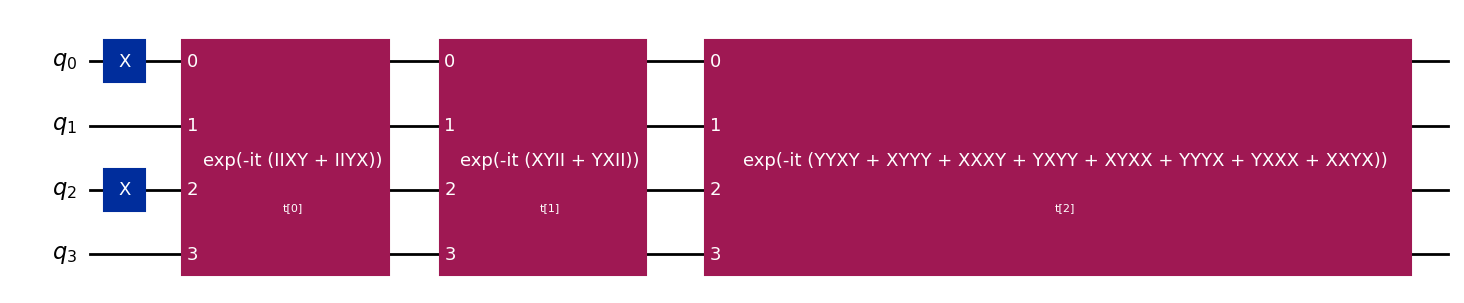

In [14]:
ansatz.decompose().draw('mpl')

In [15]:
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver

numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(es_problem)

qeom_results = qeom_excited_states_solver.solve(es_problem)

print(numpy_results)
print("\n\n")
print(qeom_results)

/home/marc/.local/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:555: UserWarning: Device does not support global phase; global phase of 5.497787143782138 will not be included in Braket circuit
  warnings.warn(


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -0.882722150245
> Total excited state energy (Hartree): -0.162753155796
  2: 
* Electronic excited state energy (Hartree): -0.224911252831
> Total excited state energy (Hartree): 0.495057741618
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  2:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
    

### code relevant for braket (estimator) with IQM - garnet

In [4]:
from braket.aws import AwsDevice
from braket.devices import Devices
from braket.jobs import hybrid_job, save_job_result
from qiskit.primitives import BackendEstimator, BackendEstimatorV2
from qiskit_braket_provider import BraketLocalBackend

In [5]:
# get backend: here SV1
from qiskit_braket_provider import BraketProvider

sv1 = AwsDevice(Devices.Amazon.SV1)
backend = BraketProvider().get_backend("Garnet")

In [6]:
# create our own estimator
#backend = BraketLocalBackend()
estimator = BackendEstimator(backend=backend, options={"shots": 1})
#estimator = BackendEstimatorV2(backend=backend)
#estimator.options.default_shots = 10

In [7]:
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
    ),
)

#ansatz.remove_final_measurements()

#estimator = Estimator()
# This first part sets the ground state solver
# see more about this part in the ground state calculation tutorial
slsqp = SLSQP(maxiter=1)
solver = VQE(estimator, ansatz, slsqp)
solver.initial_point = [0.0] * ansatz.num_parameters
gse = GroundStateEigensolver(mapper, solver)

# The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)

In [ ]:
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver

numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(es_problem)

qeom_results = qeom_excited_states_solver.solve(es_problem)

print(numpy_results)
print("\n\n")
print(qeom_results)

/home/marc/.local/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:555: UserWarning: Device does not support global phase; global phase of 3.9269908169872414 will not be included in Braket circuit
  warnings.warn(
